# Setup

In [1]:
#Import Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,\
StratifiedKFold,\
RandomizedSearchCV,\
GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import make_scorer, recall_score,\
    roc_auc_score, accuracy_score, f1_score, precision_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
#Import my own churn functions
from utils.churn_functions import clean, parameter_tuning, models, evaluation

# Data Cleaning and Preparation

In [2]:
#Read in data
df = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
#Print an overview of the data set
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#Explore columns and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
#Print list of categorical columns
cat_cols = list(df.select_dtypes(exclude=[np.number]).columns.values)
cat_cols

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'TotalCharges',
 'Churn']

In [5]:
#Ensure each customerID is included only once in the data
len(df) == len(df['customerID'].unique())

True

In [6]:
#Print list of numeric columns
numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
numeric_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges']

In [7]:
#Identify any uniform features. 
#If any features are returned, remove them from the data as they will not add any predictiveness
uniform_cols = clean.identify_uniform(df)

The following features are uniform:
 []


In [8]:
#Identify categorical features with more than 100 unique values.
#Consider binning, deleting, or converting to a continuous numeric variable
df = clean.identify_diverse_cat(df, 100, delete=False)

customerID column has 7043 categories and should be binned or transformed
TotalCharges column has 6531 categories and should be binned or transformed


In [9]:
#As seen above, the customerID column is very diverse, and will not add predictiveness to the model.
#Therefore, we will drop the customerID column
df_new = df.drop(['customerID'], axis=1)

In [10]:
#The TotalCharges feature seems as though it should actually be a numeric variable
#We will look into this more by viewing the unique values of the 'TotalCharges' column
df_new['TotalCharges'].unique()

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [11]:
df_new['TotalCharges'] = df_new['TotalCharges'].apply(clean.convert_to_float_try_except)

In [12]:
df_new['TotalCharges'].dtype

dtype('float64')

In [13]:
#Examine data
df_new.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


From examining data, it is clear that there are several columns containing only "Yes/No" values that can 
be converted to "1/0". Use the to_binary function to convert those columns below.

In [14]:
df_new = clean.to_binary(df_new)

/Users/gabbynyirjesy/Documents/GitHub/Churn-Modeling/utils/churn_functions.py:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'No' in df[col].unique() and 'Yes' in df[col].unique():


In [15]:
#As seen below, the "Yes/No" columns have been converted to binary
df_new.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,1,0,1,0,1,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,Male,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,Male,0,0,0,45,0,1,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


In [16]:
#Check to see if there are any N/A's remaining in the data (may need to impute)
df_new.isna().values.any()

False

In [17]:
#Check to see if there are any null values remaining in the data (may need to impute)
df_new.isnull().values.any()

False

In [18]:
#Print numeric columns
numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
numeric_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges']

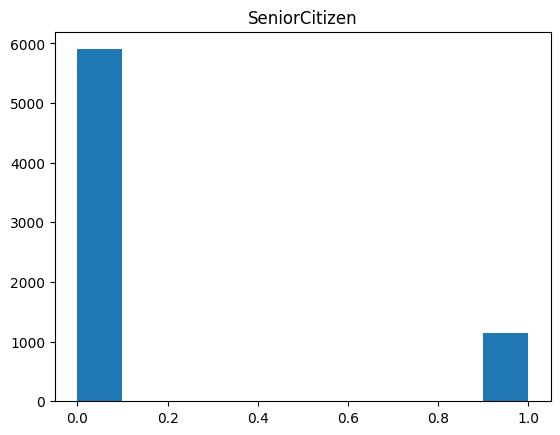

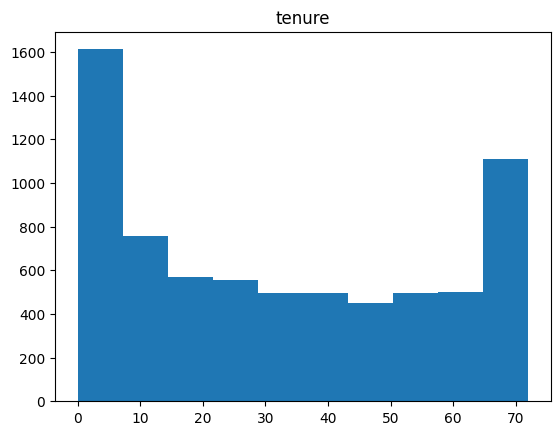

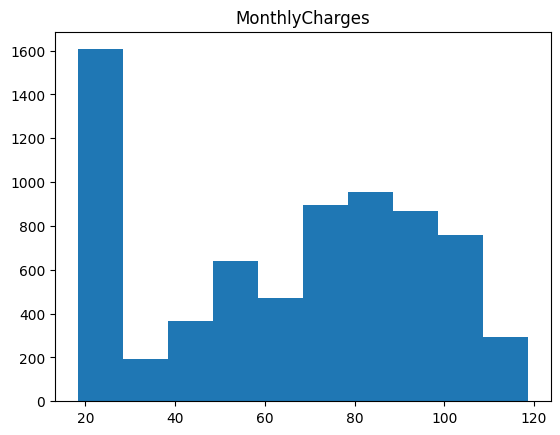

In [19]:
#Investigate distribution of values for numeric columns
for col in numeric_cols:
    plt.title(col)
    plt.hist(df_new[col])
    plt.show()

From the distributions above, there do not seem to be any outliers in the distributions.

In [20]:
#Explore the percentage of churners vs. non-churners in the data
df_new['Churn'].value_counts(normalize=True)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

There is a higher percentage of non-churners than churners in the dataset, which may skew the model. To correct for this, we will determine the class imbalance and re-sample the data within the respective models later in the code.

In [21]:
#Set seed for reproducability
seed = 111

In [22]:
#Define the binary target variable for classification model
binary_var = 'Churn'

In [23]:
#Separate data into x and y
x = df_new[df_new.columns.difference([binary_var])]
y = df_new[binary_var]

# Model Creation

## Random Forest Model

In [24]:
#Label encode the categorical columns within the x data since categorical variables are not accepted in
#Random Forest models
x_cat = clean.label_encoding(x)

/Users/gabbynyirjesy/Documents/GitHub/Churn-Modeling/utils/churn_functions.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].apply(str)
/Users/gabbynyirjesy/Documents/GitHub/Churn-Modeling/utils/churn_functions.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = label_encoder.fit_transform(df[col])


In [25]:
#Ensure all columns are numeric
x_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Contract          7043 non-null   int64  
 1   Dependents        7043 non-null   int64  
 2   DeviceProtection  7043 non-null   int64  
 3   InternetService   7043 non-null   int64  
 4   MonthlyCharges    7043 non-null   float64
 5   MultipleLines     7043 non-null   int64  
 6   OnlineBackup      7043 non-null   int64  
 7   OnlineSecurity    7043 non-null   int64  
 8   PaperlessBilling  7043 non-null   int64  
 9   Partner           7043 non-null   int64  
 10  PaymentMethod     7043 non-null   int64  
 11  PhoneService      7043 non-null   int64  
 12  SeniorCitizen     7043 non-null   int64  
 13  StreamingMovies   7043 non-null   int64  
 14  StreamingTV       7043 non-null   int64  
 15  TechSupport       7043 non-null   int64  
 16  TotalCharges      7043 non-null   float64


In [26]:
#Split the encoded data into train and test sets
x_cat_train, x_cat_test, y_cat_train, y_cat_test = train_test_split(x_cat, y, stratify=y, 
                                                                    test_size=0.2, random_state=seed)

In [27]:
#Define random_grid for parameter tuning random search
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
                          'max_features': ['auto', 'sqrt'],
                          'max_depth': [int(x) for x in np.linspace(100, 110, num=2)],
                          'min_samples_split': [2, 5, 10],
                          'min_samples_leaf': [1, 2, 5],
                          'bootstrap': [True, False],
                          'class_weight': ['balanced']}

In [ ]:
#Run a random search of Random Forest parameters to find best initial hyper parameters. Use stratified k-fold
#cross-validation in randomsearch
params = parameter_tuning.randomsearch(seed, x_cat, y, random_grid, 'rf')

In [29]:
print(params)

{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 110, 'class_weight': 'balanced', 'bootstrap': False}


In [30]:
#Define random grid for grid search parameter tuning
random_grid = {'n_estimators': [600, 700],
                          'max_features': ['auto','sqrt'],
                          'max_depth': [110],
                          'min_samples_split': [4, 5, 6],
                          'min_samples_leaf': [5, 6],
                          'bootstrap': [False],
                          'class_weight': ['balanced']}

In [ ]:
#Run a more intensive grid search to tune hyper parameters for Random Forest Model.  Use stratified k-fold
#cross-validation in randomsearch
params = parameter_tuning.gridsearch(seed, x_cat, y, random_grid, 'rf')

In [32]:
print(params)

{'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 110, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 700}


In [33]:
#Run the preliminary Random Forest Model
rf_mod = models.rf_model(x_cat_train, y_cat_train, seed, **params)

In [34]:
#Explore feature importance
rf_mod_imp = pd.DataFrame({'Gini-importance': rf_mod.feature_importances_, 'col': x_cat_train.columns})
rf_mod_imp = rf_mod_imp.sort_values(['Gini-importance', 'col'], ascending=False)
#Keep features with a Gini-importance >= 0.01
rf_mod_imp = rf_mod_imp[rf_mod_imp['Gini-importance'] >= 0.01]
print(rf_mod_imp)

    Gini-importance               col
0          0.200340          Contract
18         0.150175            tenure
16         0.130005      TotalCharges
4          0.118565    MonthlyCharges
7          0.087807    OnlineSecurity
15         0.073854       TechSupport
3          0.050807   InternetService
10         0.033562     PaymentMethod
6          0.029525      OnlineBackup
2          0.024927  DeviceProtection
8          0.019720  PaperlessBilling
17         0.014670            gender
9          0.011571           Partner
13         0.011132   StreamingMovies
5          0.010892     MultipleLines


In [35]:
#Keep top importance features in the x data
x_rf_imp = x_cat[rf_mod_imp['col']]
x_train_rf_imp = x_cat_train[rf_mod_imp['col']]
x_test_rf_imp = x_cat_test[rf_mod_imp['col']]

In [36]:
#Run Random Forest model with only important features
rf_mod = models.rf_model(x_train_rf_imp, y_cat_train, seed, **params)

In [37]:
#Use Random Forest model to make predictions on train and test sets
y_pred_train_rf, y_pred_test_rf = evaluation.predictions(rf_mod, x_train_rf_imp, x_test_rf_imp)

In [38]:
#Examine model performance metrics
rf_results = evaluation.results(y_cat_train, y_cat_test, y_pred_train_rf, y_pred_test_rf)

In [39]:
print(rf_results)

               Test     Train
Metrics                      
AUC        0.750784  0.896052
Accuracy   0.769340  0.872382
F1         0.620770  0.797408
Recall     0.711230  0.946488
Precision  0.550725  0.688900


Random Forest seems to be slightly overfitting. Experiment with XGBoost model to see if there is better performance.

## XGBoost Model

In [40]:
#Define scale_pos weight term to compensate for class imbalance in XGBoost model
scale_pos = y_cat_train.value_counts()[0]/y_cat_train.value_counts()[1]

In [41]:
#Create random grid for random search parameter tuning
random_grid = {'min_child_weight': [1, 5, 10],
                          'gamma': [0.5, 1, 1.5, 2, 5],
                          'subsample': [0.6, 0.8, 1.0],
                          'colsample_bytree': [0.6, 0.8, 1.0],
                          'max_depth': [3, 4, 5],
                          'scale_pos_weight': [scale_pos]}

In [ ]:
#Run a random search of XGboost parameters to find best initial hyper parameters
params = parameter_tuning.randomsearch(seed, x_cat, y, random_grid, 'xgboost')

In [43]:
print(params)

{'subsample': 1.0, 'scale_pos_weight': 2.768561872909699, 'min_child_weight': 1, 'max_depth': 3, 'gamma': 0.5, 'colsample_bytree': 0.6}


In [44]:
#Define random grid for grid search parameter tuning
random_grid = {'min_child_weight': [1, 2],
                          'gamma': [0.5, 1, 1.5],
                          'subsample': [0.9, 1],
                          'colsample_bytree': [0.5, 0.6, 0.7],
                          'max_depth': [3, 4, 5],
                          'scale_pos_weight': [scale_pos]}

In [ ]:
#Run a more intensive grid search to tune hyper parameters for XGBoost Model.  Use stratified k-fold
#cross-validation in randomsearch
params = parameter_tuning.gridsearch(seed, x_cat, y, random_grid, 'xgboost')

In [46]:
print(params)

{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 2.768561872909699, 'subsample': 1}


In [47]:
#Run the preliminary XGboost Model
xgb_mod = models.xgboost_model(x_cat_train, y_cat_train, seed, **params)

In [48]:
print(params)

{'colsample_bytree': 0.6, 'gamma': 0.5, 'max_depth': 3, 'min_child_weight': 1, 'scale_pos_weight': 2.768561872909699, 'subsample': 1}


In [49]:
#Explore feature importance
xgb_mod_imp = pd.DataFrame({'Gini-importance': xgb_mod.feature_importances_, 'col': x_cat_train.columns})
xgb_mod_imp = xgb_mod_imp.sort_values(['Gini-importance', 'col'], ascending=False)
#Keep features with a Gini-importance >= 0.01
xgb_mod_imp = xgb_mod_imp[xgb_mod_imp['Gini-importance'] >= 0.01]
print(xgb_mod_imp)

    Gini-importance               col
15         0.319318       TechSupport
7          0.212983    OnlineSecurity
3          0.105851   InternetService
0          0.102419          Contract
8          0.027035  PaperlessBilling
2          0.025753  DeviceProtection
16         0.024167      TotalCharges
18         0.022297            tenure
5          0.021810     MultipleLines
6          0.019599      OnlineBackup
14         0.016081       StreamingTV
10         0.015703     PaymentMethod
4          0.015678    MonthlyCharges
13         0.015300   StreamingMovies
1          0.014034        Dependents
12         0.012765     SeniorCitizen
17         0.012716            gender


In [50]:
#Keep top importance features in the x data
x_xgb_imp = x_cat[xgb_mod_imp['col']]
x_train_xgb_imp = x_cat_train[xgb_mod_imp['col']]
x_test_xgb_imp = x_cat_test[xgb_mod_imp['col']]

In [51]:
#Run XGboost Model
xgb_mod = models.xgboost_model(x_train_xgb_imp, y_cat_train, seed, **params)

In [52]:
#Make predictions on train and test sets
y_pred_train_xgb, y_pred_test_xgb = evaluation.predictions(xgb_mod, x_train_xgb_imp, x_test_xgb_imp)

In [53]:
#Examine model metric esults
xgb_results = evaluation.results(y_cat_train, y_cat_test, y_pred_train_xgb, y_pred_test_xgb)
print(xgb_results)

               Test     Train
Metrics                      
AUC        0.759310  0.820598
Accuracy   0.753016  0.801384
F1         0.624190  0.697158
Recall     0.772727  0.861538
Precision  0.523551  0.585455


## CatBoost Model

In [24]:
#Split data into test, train, and validation sets
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.15, random_state=seed)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.15, random_state=seed)

In [25]:
#Define scale_pos weight term to compensate for class imbalance in CatBoost model
scale_pos = y_train.value_counts()[0]/y_train.value_counts()[1]

In [26]:
#Create random grid for random search parameter tuning
random_grid = {'learning_rate': [0.03, 0.1],
                          'l2_leaf_reg': [1, 3, 5, 7, 9],
                          'depth': [4, 6, 10],
                          'scale_pos_weight': [scale_pos]}

In [ ]:
#Run a random search of XGboost parameters to find best initial hyper parameters
params = parameter_tuning.randomsearch(seed, x_cat, y, random_grid, 'catboost')

In [58]:
print(params)

{'scale_pos_weight': 2.766099185788305, 'learning_rate': 0.03, 'l2_leaf_reg': 9, 'depth': 4}


In [59]:
#Create random grid for grid search parameter tuning
random_grid = {'learning_rate': [0.01, 0.03, 0.05],
                          'l2_leaf_reg': [8, 9, 10],
                          'depth': [4, 5, 6],
                          'scale_pos_weight': [scale_pos]}

In [ ]:
#Run a more intensive grid search to tune hyper parameters for CatBoost Model.  Use stratified k-fold
#cross-validation in randomsearch
params = parameter_tuning.gridsearch(seed, x_cat, y, random_grid, 'catboost')

In [35]:
print(params)

{'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.01, 'scale_pos_weight': 2.766099185788305}


In [36]:
#Run preliminary catboost model
catboost_mod = models.catboost_model(x_train, x_val, y_train, y_val, seed, use_best_mod=True, **params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [37]:
#Explore feature importances
feature_importances = pd.DataFrame({'imp': catboost_mod.feature_importances_, 'col': x_train.columns})
#Keep only top 10 most important features for model
feature_importances = feature_importances.sort_values(['imp', 'col'], ascending=False).iloc[:10]
print(feature_importances)

          imp               col
0   59.376254          Contract
4   16.409367    MonthlyCharges
7    8.449435    OnlineSecurity
15   6.741533       TechSupport
18   5.709804            tenure
16   1.771980      TotalCharges
8    0.856150  PaperlessBilling
6    0.685477      OnlineBackup
17   0.000000            gender
14   0.000000       StreamingTV


In [38]:
#Keep top 10 most important features in x data sets to remove noise in the model
x_train_catboost_imp = x_train[feature_importances['col']]
x_val_catboost_imp = x_val[feature_importances['col']]
x_test_catboost_imp = x_test[feature_importances['col']]

In [39]:
#Re-run catboost model with most important features only
catboost_mod = models.catboost_model(x_train_catboost_imp, x_val_catboost_imp, 
                                     y_train, y_val, seed, use_best_mod=False, **params)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [40]:
#Predict y train and test sets using CatBoost model
y_pred_train, y_pred_test = evaluation.predictions(catboost_mod, x_train_catboost_imp, x_test_catboost_imp)

In [41]:
#Evaluate catboost model performance
catboost_results = evaluation.results(y_train, y_test, y_pred_train, y_pred_test)
print(catboost_results)

               Test     Train
Metrics                      
AUC        0.752542  0.752781
Accuracy   0.706717  0.711478
F1         0.605598  0.607487
Recall     0.850000  0.840859
Precision  0.470356  0.475513


As seen above, the CatBoost model should be selected for this data set because the model has good recall and does not seem to be overfitting. Recall will capture the most positive instances and the cost of contacting customers who are identified as churners but actually were not (false positives) is low, so this is the metric of choice.